# Example based on our README.md
1. Dataset download
2. Pre-training
3. Fine-tuning
4. Inference


### 1. Download the dataset

In [1]:
# using the cli
!python -m wejepa.datasets.download --dataset-root ./data --dataset-name tsbpp/fall2025_deeplearning --splits train

Split 'train' available under /home/long/PhD/Coursework/Deep_Learning/Project/Code/ijepa/experiments/data


### 2. Pre-training the model

In [17]:
# using the cli

# print the config
!python -m wejepa.train.pretrain --config hf_config.json --print-config

# pretrain the model
!python -m wejepa.train.pretrain --config hf_config.json

<frozen runpy>:128: RuntimeWarning: 'wejepa.train.pretrain' found in sys.modules after import of package 'wejepa.train', but prior to execution of 'wejepa.train.pretrain'; this may result in unpredictable behaviour
{
  "data": {
    "dataset_root": "/home/long/PhD/Coursework/Deep_Learning/Project/Code/ijepa/experiments/data",
    "dataset_name": "cifar10",
    "image_size": 32,
    "train_batch_size": 256,
    "eval_batch_size": 512,
    "num_workers": 4,
    "pin_memory": true,
    "persistent_workers": true,
    "prefetch_factor": 2,
    "crop_scale": [
      0.6,
      1.0
    ],
    "color_jitter": 0.5,
    "use_color_distortion": true,
    "use_horizontal_flip": true,
    "normalization_mean": [
      0.5071,
      0.4867,
      0.4408
    ],
    "normalization_std": [
      0.2675,
      0.2565,
      0.2761
    ],
    "use_fake_data": false,
    "fake_data_size": 512
  },
  "mask": {
    "target_aspect_ratio": [
      0.75,
      1.5
    ],
    "target_scale": [
      0.15,
    

In [ ]:
# programmatically
from wejepa import default_config, launch_pretraining
cfg = default_config()
launch_pretraining(cfg)

### 3. Fine tuning the model

In [3]:
# using the cli
!python -m wejepa.train.finetune \
    --checkpoint outputs/ijepa/ijepa_epoch_0005.pt \
    --epochs 10 \
    --batch-size 256 \
    --lr 3e-4 \
    --num-classes 100

<frozen runpy>:128: RuntimeWarning: 'wejepa.train.finetune' found in sys.modules after import of package 'wejepa.train', but prior to execution of 'wejepa.train.finetune'; this may result in unpredictable behaviour
[Linear probe] Epoch 1/10 | loss=4.5212 | train_acc=0.027 | val_acc=0.040
[Linear probe] Epoch 2/10 | loss=4.4321 | train_acc=0.038 | val_acc=0.048
[Linear probe] Epoch 3/10 | loss=4.3897 | train_acc=0.041 | val_acc=0.052
[Linear probe] Epoch 4/10 | loss=4.3605 | train_acc=0.046 | val_acc=0.058
[Linear probe] Epoch 5/10 | loss=4.3410 | train_acc=0.048 | val_acc=0.061
[Linear probe] Epoch 6/10 | loss=4.3247 | train_acc=0.049 | val_acc=0.063
[Linear probe] Epoch 7/10 | loss=4.3138 | train_acc=0.051 | val_acc=0.066
[Linear probe] Epoch 8/10 | loss=4.3069 | train_acc=0.051 | val_acc=0.067
[Linear probe] Epoch 9/10 | loss=4.2974 | train_acc=0.054 | val_acc=0.068
[Linear probe] Epoch 10/10 | loss=4.2919 | train_acc=0.055 | val_acc=0.070


In [ ]:
# programmatically
from wejepa.train import FinetuneConfig, train_linear_probe

ft_cfg = FinetuneConfig(
    checkpoint_path="outputs/ijepa/ijepa_epoch_0005.pt",
    epochs=5,
    batch_size=128,
    learning_rate=1e-3,
)
train_linear_probe(ft_cfg)

### 4. Running Inference

Image shape: torch.Size([1, 3, 32, 32])


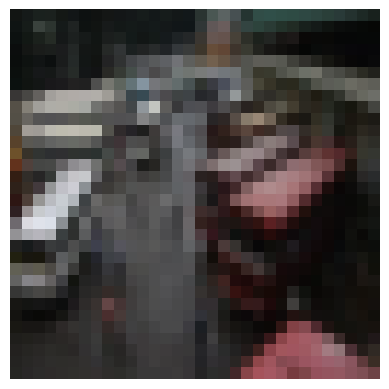

In [13]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from datasets import load_dataset
from PIL import Image


from wejepa.train import load_backbone_from_checkpoint
from wejepa import default_config

cfg = default_config()
backbone = load_backbone_from_checkpoint("outputs/ijepa/ijepa_epoch_0005.pt", cfg)
backbone.eval()

transform = transforms.Compose([
    transforms.Resize(cfg.data.image_size),
    transforms.ToTensor(),
    transforms.Normalize(cfg.data.normalization_mean, cfg.data.normalization_std),
])

ds = load_dataset(
    "./data/tsbpp___fall2025_deeplearning",
    split="train",
)
# grab an image from the dataset
image = transform(ds[0]["image"]).unsqueeze(0)
print(f"Image shape: {image.shape}")

# remove batch dimension and convert to numpy
img_np = image.squeeze(0).permute(1, 2, 0).cpu().numpy()

# undo normalization for display
mean = np.array(cfg.data.normalization_mean)
std = np.array(cfg.data.normalization_std)
img_np = (img_np * std) + mean
img_np = np.clip(img_np, 0, 1)

plt.imshow(img_np)
plt.axis('off')
plt.show()

with torch.no_grad():
    tokens = backbone(image)
    pooled = tokens.mean(dim=1)  # embeddings for downstream heads

# TODO: use the embeddings `pooled` for downstream tasks